In this post, I would like to introduce a PowerShell function to create new split-panes for the Windows Terminal. One of the many great features of the Windows Terminal is the ability to split a window into panes:

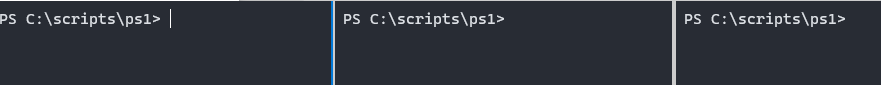

While this functionality has been introduced quite early with the [releases of Windows Terminal](https://github.com/microsoft/terminal/releases) the team has added additional functionality recently that expands the functionality. In this post, I'm using the current latest beta release v1.7.572.0. This is also to workaround a bug where the -windows 0 option does not work see [here](https://github.com/microsoft/terminal/issues/9628). I'm using the `windowingBehavior:"useExisting"` global setting described [here](https://github.com/microsoft/terminal/pull/9118) to ensure that new instances of a Terminal (including new panes) launch in the same window.

While new panes can be created using keyboard shortcuts ([documentation](https://docs.microsoft.com/en-us/windows/terminal/customize-settings/actions)) I'm more interested in doing this dynamically through code. I would like to span multiple panes with specific code being executed through PowerShell. 

The key to do this is within the [commmandline parameters for the Windows Terminal executable (wt.exe)](https://docs.microsoft.com/en-us/windows/terminal/command-line-arguments?tabs=windows). wt.exe supports the split-pane or sp command with several sub-commands:

| Sub-command         | Shorthand | Description                                                                                                  |
|---------------------|-----------|--------------------------------------------------------------------------------------------------------------|
| --horizontal        | -H        | Split the parent pane horizontally  to create the new pane.                                                  |
| --vertical          | -V        | Split the parent pane vertically to create the new pane.                                                     |
| profile-name        | -p        | The name of the Windows terminal to use for the new pane.                                                    |
| --startingDirectory | --d       | The directory the new pane will start in.                                                                    |
| commandline         |           | The commandline to execute when starting  the pane.This is the default parameter.                            |
| --title             |           | The title of the tab to start the pane in.                                                                   |
| --tabcolor          |           | The color of the tab to start the pane in.                                                                   |
| --size              | -s        | Float between 0.0-1.0. Specifies the portion of the parent pain that should be used to  create the new pane. |

Let's look at an example how to use the sp command to create a new pane. With `start wt 'sp -p "NoProfile"'`

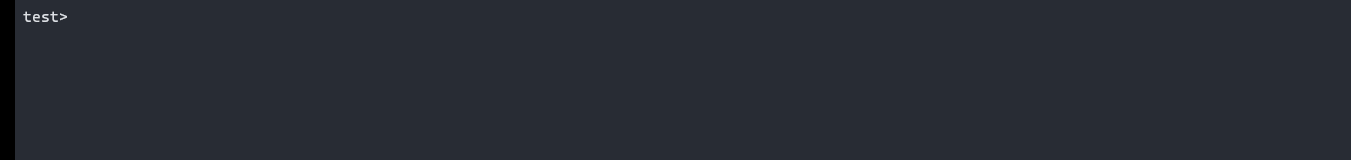

Without providing a commandline we don't have much control over the new pane. The new pane is running within a separate process but within the same runspace. We can use the `Enter-PSHostProcess` cmdlet (the interprocess communication is based on named pipes that you can inspect using the `Get-ChildItem -Path "\\.\pipe\" -Filter '*pshost*'` command) to enter an interactive session connecting to a new pane. This way commands can be executed in the context of the new pane, but the output will be directed to the parent pane's host. The only commands that I found to be working are the [console]::Write... methods and the [System.Environment]::Exit method to shut down the panel from the parent panel (in addition to this one could also utilize `Get-Runspace` and `Debug-Runspace` to break into code that runs in the child pane and manipulate variables but that seemed to cumbersome too me).

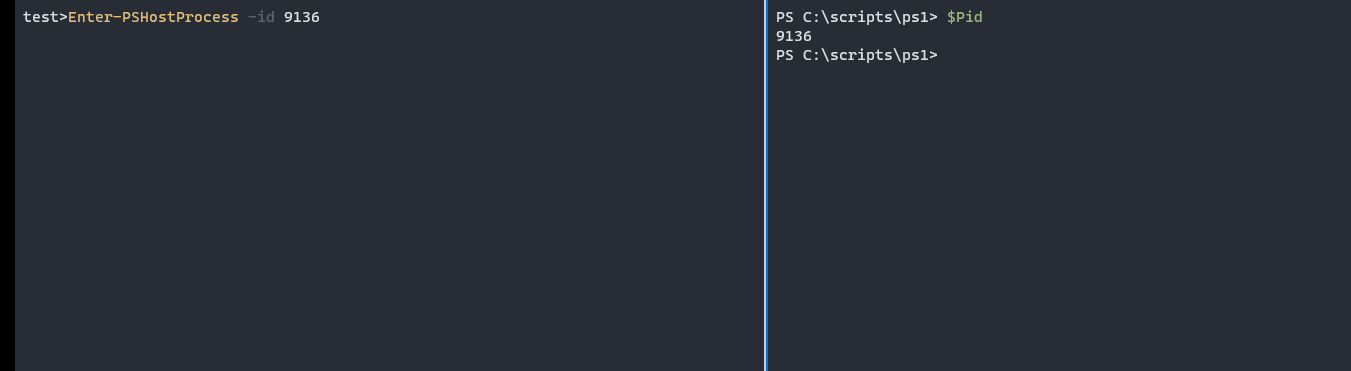

Here is a full example of a wt.exe command using the commandline parameter to start a new pane executing PowerShell's `Get-Process` cmdlet. Notice that we need to use the -noexit commandline argument in order for this to work (noProfile is optional but speeds up the execution of the command).

In [1]:
start wt 'sp -p "NoProfile" powershell -nop -noexit -command Get-Process'

The below script needs to be able to find the current output cell; this is an easy method to get it.

My requirements for a PowerShell function wrapper for the split-pane command are:
- Ability to specify the orientation, profilename, and size of the new pane by parameter
- Ability to specify a script block with code to be executed when the new pane is started.
- Ability to specify Begin and End script blocks for code to be executed in a loop repeating by a specified interval.
   - This is for repeatedly run code that updates the screen at a certain interval (see weather example).
- Return the process Id of the new pane in order to optionally control it from the parent pane.

Here is the function that implements those requirements.

In [ ]:
function New-SplitPane{ 
    [CmdletBinding()]
    [CmdletBinding(DefaultParameterSetName='Process')]
    Param(
        [Parameter(Position=0,ParameterSetName='Process')]
        [ScriptBlock]$Begin,
        [Parameter(Mandatory,Position=1,ParameterSetName='Process')]
        [ScriptBlock]$Process,
        [Parameter(Mandatory,ParameterSetName='Process')]
        [TimeSpan]$Interval,
        [Parameter(ParameterSetName='Static')]
        $ScriptBlock,
        [ValidateRange(0.0,1.0)]
        [float]$Size,
        $ProfileName = 'NoProfile',
        [ValidateSet('Vertical','Horizontal')]
        $Orientation
    )
    #keep track of the powershell process id's prior to invoking the new panel process
    $before = Get-Process powershell
    $command = ' sp'
    if ($ProfileName){ $command += " -p ""$ProfileName""" }
    if ($Orientation){ $command += " --$($Orientation.ToLower())" }
    if ($PSCmdlet.ParameterSetName -eq 'Process'){
        $scriptText = "{`n"
        if ($Begin){ 
            $scriptText += $Begin.ToString() 
        } 
        #wrap the process block into an endless loop and the specified sleep interval
        $scriptText += 'while($true){' + $Process.ToString()
        $scriptText += 'sleep -Seconds ' + $Interval.TotalSeconds + '}}'
    }
    else{
        $scriptText = $ScriptBlock
    }
    $encodedCommand = [Convert]::ToBase64String([System.Text.Encoding]::Unicode.GetBytes($scriptText))
    $command += ' powershell -nop -noexit -encodedCommand ' + $encodedCommand
    start  wt $command -Wait
    #retrieve the new process id and return it
    (Get-Process powershell).Where{$_.id -notin $before.Id}
}

Here is the syntax of the function with two parameter sets using my [Get-HelpSyntax](https://powershellone.wordpress.com/2018/07/25/powershell-get-command-syntax-output-explained/) function:

In [3]:
Get-HelpSyntax New-SplitPane

Parameters are listed in order of their positional index (e.g. position=0 first)
------------------------------------------------------------------------------------------------------------------------

Syntax                      Description
------                      -----------
-PARAMNAME <PARAMVALUE>     A required parameter that can be used only by name:
[-PARAMNAME] <PARAMVALUE>   A required parameter that can be used by position or name:
[PARAMNAME]                 A switch parameter (switches are always optional and can only be used …
[[-PARAMNAME] <PARAMVALUE>] An optional parameter that can be used by position or name:
[-PARAMNAME <PARAMVALUE>]   An optional parameter that can only be used by name:
------------------------------------------------------------------------------------------------------------------------

ParameterSet:Process
New-SplitPane

   [[-Begin] <scriptblock>]
   [-Process] <scriptblock>
   -Interval <timespan>
   [-Size <float>]
   [-ProfileName <Object

With `New-SplitPane` we can create panes with code that runs repeatedly in order to update the new pane with information. An example of this is using the [wttr.in](https://github.com/chubin/wttr.in) API to get continuously updated weather information in a separate pane.

In [ ]:
$handle = New-SplitPane -Begin {
    #suppress progress output
    $progressPreference = 'SilentlyContinue'
    #hide the cursor
    Write-Host -NoNewLine "$([char]27)[?25l"
} -Process {
        cls
        Write-Host "`n$(Get-Date)"
        $weather = (Invoke-WebRequest "http://wttr.in/Dublin?0" -UserAgent curl).content.Split("`n")
        $weather | foreach {Write-Host $_}
}  -Interval ([TimeSpan]::FromSeconds(3))

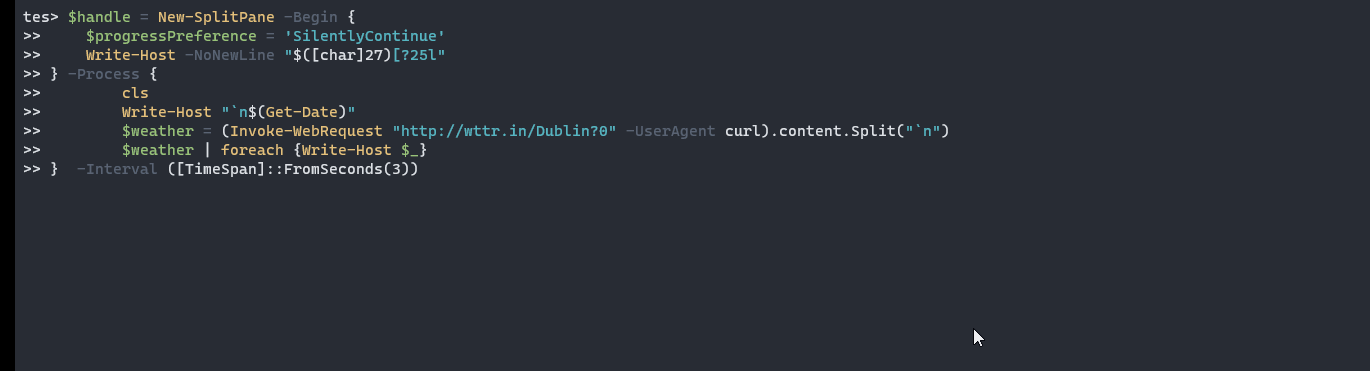

Here is another example creating additinoal panes based on [ticker](https://github.com/achannarasappa/ticker) and [ntop](https://github.com/gsass1/NTop).

In [ ]:
$handle2 = New-SplitPane -ScriptBlock {
    $symbols = 'BTC-USD,EURUSD=X,GC=F,^GDAXI,^DJI,^IXIC'
    ticker.exe -w $symbols  --show-summary --show-fundamentals
} -Size 1 -Orientation Horizontal

$handle3 = New-SplitPane -ScriptBlock {
    cls
    ntop
} -Size 1 

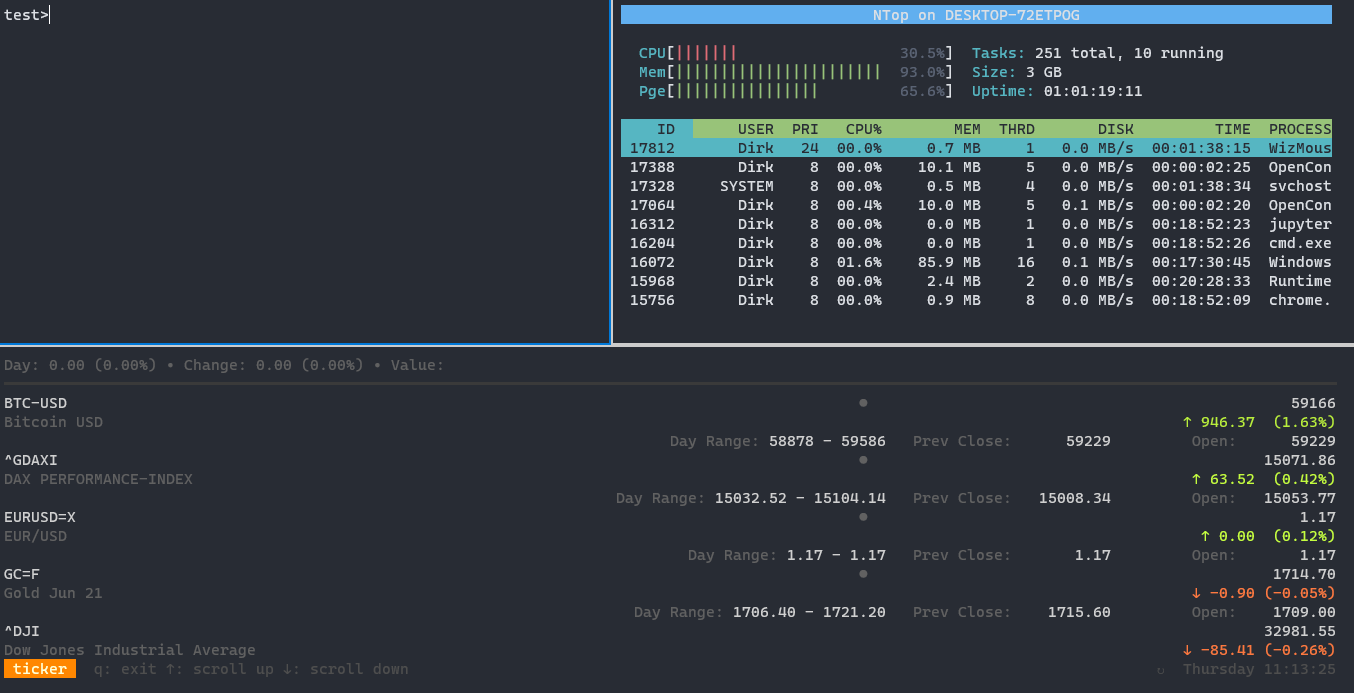

I hope that you enjoy using the function to create new split panes in the Windows Terminal dynamically. I'd love to see some examples of how you use this.